In [1]:
import polars as pl
import lightgbm as lgb
import yaml

from src.metrics import rmse
from src.features.preprocess import Preprocessor
from src.config.preprocess import PreprocessorConfig

train_df = pl.read_csv("../dataset/projectA_vehicle_train.csv").drop(
    "posting_date", "id"
)
val_df = pl.read_csv("../dataset/projectA_vehicle_val.csv").drop("posting_date", "id")
test_df = pl.read_csv("../dataset/projectA_vehicle_test.csv").drop("posting_date", "id")


# load preprocessor and LightGBM parameters
preprocessor_config_reg = PreprocessorConfig.from_yaml(
    "../params/best_preprocessor_config_reg.yaml"
)
preprocessor_config_anomaly = PreprocessorConfig.from_yaml(
    "../params/best_preprocessor_config_anomaly.yaml"
)

with open("../params/best_lgb_params_reg.yaml", "r") as f:
    lgb_params_reg = yaml.safe_load(f)
with open("../params/best_lgb_params_anomaly.yaml", "r") as f:
    lgb_params_anomaly = yaml.safe_load(f)


# Regression

In [2]:
# preprocess
preprocessor_reg = Preprocessor(**preprocessor_config_reg.to_dict())
train_df_preprocessed_reg, val_df_preprocessed_reg, test_df_preprocessed_reg = (
    preprocessor_reg.run(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
    )
)

train_set_reg = lgb.Dataset(
    train_df_preprocessed_reg.drop("price").to_pandas(),
    train_df_preprocessed_reg["price"].to_pandas(),
)
val_set_reg = lgb.Dataset(
    val_df_preprocessed_reg.drop("price").to_pandas(),
    val_df_preprocessed_reg["price"].to_pandas(),
    reference=train_set_reg,
)

In [3]:
model_reg = lgb.train(
    lgb_params_reg,
    train_set_reg,
    valid_sets=[val_set_reg],
    num_boost_round=1000,
)

In [4]:
pred_price_train = model_reg.predict(
    train_df_preprocessed_reg.drop("price").to_pandas()
)
pred_price_val = model_reg.predict(val_df_preprocessed_reg.drop("price").to_pandas())
pred_price_test = model_reg.predict(test_df_preprocessed_reg.drop("price").to_pandas())

rmse_train = rmse(
    train_df_preprocessed_reg["price"].to_numpy(),
    pred_price_train,
)
rmse_val = rmse(
    val_df_preprocessed_reg["price"].to_numpy(),
    pred_price_val,
)
rmse_test = rmse(
    test_df_preprocessed_reg["price"].to_numpy(),
    pred_price_test,
)

print(f"RMSE Train: {rmse_train:,.2f}")
print(f"RMSE Val: {rmse_val:,.2f}")
print(f"RMSE Test: {rmse_test:,.2f}")


RMSE Train: 2,896.36
RMSE Val: 8,900.36
RMSE Test: 6,720.97


# anomaly detection

In [22]:
preprocessor_anomaly = Preprocessor(**preprocessor_config_anomaly.to_dict())
datasets = preprocessor_anomaly.run(train_df, val_df, test_df)
train_df_preprocessed_anomaly = datasets[0]
val_df_preprocessed_anomaly = datasets[1]
test_df_preprocessed_anomaly = datasets[2]

# add anomaly column
# anomaly_soft_label = 1 / (1 + ((pl.col("price") - pl.lit(40_000)) * -0.0005).exp())
# train_df_preprocessed_anomaly = train_df_preprocessed_anomaly.with_columns(
#     anomaly_soft_label.alias("anomaly_soft_label")
# )
# val_df_preprocessed_anomaly = val_df_preprocessed_anomaly.with_columns(
#     anomaly_soft_label.alias("anomaly_soft_label")
# )
# test_df_preprocessed_anomaly = test_df_preprocessed_anomaly.with_columns(
#     anomaly_soft_label.alias("anomaly_soft_label")
# )

anomaly_flag_expr = (pl.col("price") > 50_000).alias("is_anomaly")
train_df_preprocessed_anomaly = train_df_preprocessed_anomaly.with_columns(
    anomaly_flag_expr
)
val_df_preprocessed_anomaly = val_df_preprocessed_anomaly.with_columns(
    anomaly_flag_expr
)
test_df_preprocessed_anomaly = test_df_preprocessed_anomaly.with_columns(
    anomaly_flag_expr
)

train_set = lgb.Dataset(
    train_df_preprocessed_anomaly.drop(["is_anomaly", "price"]).to_pandas(),
    train_df_preprocessed_anomaly["is_anomaly"].to_pandas(),
)
val_set = lgb.Dataset(
    val_df_preprocessed_anomaly.drop(["is_anomaly", "price"]).to_pandas(),
    val_df_preprocessed_anomaly["is_anomaly"].to_pandas(),
    reference=train_set,
)

In [23]:
# lgb_params_anomaly["metric"] = "rmse"
# lgb_params_anomaly["objective"] = "regression"
model_anomaly = lgb.train(
    lgb_params_anomaly,
    train_set,
    valid_sets=[val_set],
    num_boost_round=1000,
)

In [24]:
anomaly_score_train = model_anomaly.predict(
    train_df_preprocessed_anomaly.drop(["is_anomaly", "price"]).to_pandas()
)
anomaly_score_val = model_anomaly.predict(
    val_df_preprocessed_anomaly.drop(["is_anomaly", "price"]).to_pandas()
)
anomaly_score_test = model_anomaly.predict(
    test_df_preprocessed_anomaly.drop(["is_anomaly", "price"]).to_pandas()
)

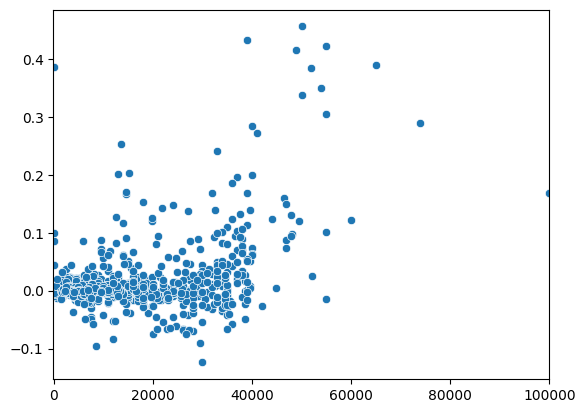

(-100.0, 100000.0)

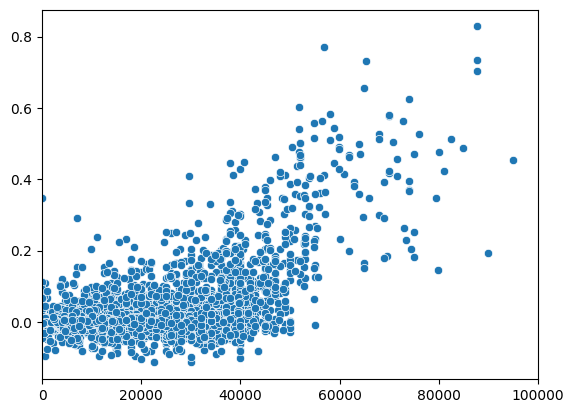

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# val set
sns.scatterplot(
    x=val_df_preprocessed_anomaly["price"].to_numpy(),
    y=anomaly_score_val,
)
plt.xlim(-100, 100_000)
plt.show()

# train set
sns.scatterplot(
    x=train_df_preprocessed_anomaly["price"].to_numpy(),
    y=anomaly_score_train,
)
plt.xlim(-100, 100_000)


# Ensemble

In [37]:
import numpy as np


def calc_weight(
    a: float, b: float, anomaly_score: np.ndarray, threshold: float
) -> np.ndarray:
    """
    Calculate the weight for the ensemble model based on the anomaly score.
    """
    mask = anomaly_score < threshold
    weight = 1.0 / (1 + np.exp(-a * anomaly_score - b))
    weight[mask] = 1.0

    return weight


def ensemble_predict(
    pred_price: np.ndarray,
    anomaly_score: np.ndarray,
    constant_pred: float,
    threshold: float,
    a: float,
    b: float,
) -> np.ndarray:
    """
    Ensemble prediction function that combines price prediction and anomaly score.
    """
    weight = calc_weight(a, b, anomaly_score, threshold)
    return weight * pred_price + (1 - weight) * constant_pred

In [45]:
len(train_df_preprocessed_reg)

7938

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    """
    Objective function for hyperparameter optimization using Optuna.
    """
    a = trial.suggest_float("a", 0.1, 100.0)
    b = trial.suggest_float("b", -100.0, 0.0)
    constant_pred = trial.suggest_float("constant_pred", 100_000, 200_000)
    threshold = trial.suggest_float("threshold", 0.0, 1.0)

    preprocessor_config_reg_dict = preprocessor_config_reg.to_dict()
    preprocessor_config_reg_dict["price_upper_bound"] = float("inf")
    preprocessor_config_reg_dict["price_lower_bound"] = 0.0

    preprocessor_reg = Preprocessor(**preprocessor_config_reg_dict)
    train_df_preprocessed_reg, val_df_preprocessed_reg, test_df_preprocessed_reg = (
        preprocessor_reg.run(
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
        )
    )

    pred_price_train = model_reg.predict(
        train_df_preprocessed_reg.drop("price").to_pandas()
    )

    ensemble_pred_train = ensemble_predict(
        pred_price_train, anomaly_score_train, constant_pred, threshold, a, b
    )

    rmse_train = rmse(
        train_df_preprocessed_reg["price"].to_numpy(),
        ensemble_pred_train,
    )

    return rmse_train


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

[I 2025-07-24 01:17:58,004] A new study created in memory with name: no-name-f2e4dd7f-a37c-4d9a-a2b7-b1b3b2b8a66b
[W 2025-07-24 01:17:58,005] Trial 0 failed with parameters: {'a': 33.339702757337626, 'b': -56.13748451710132, 'constant_pred': 195895.0616700107, 'threshold': 0.67077341468473} because of the following error: ValueError('operands could not be broadcast together with shapes (8000,) (7938,) ').
Traceback (most recent call last):
  File "/Users/shota/work/topicA/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_55011/2130055459.py", line 33, in objective
    ensemble_pred_train = ensemble_predict(
                          ^^^^^^^^^^^^^^^^^
  File "/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_55011/3009125798.py", line 29, in ensemble_predict
    return weight * pred_price + (1 - weight) * con

(8000,)


ValueError: operands could not be broadcast together with shapes (8000,) (7938,) 

In [38]:
# best pred
best_params = study.best_params
print(f"Best parameters: {best_params}")

ensemble_pred_val = ensemble_predict(
    pred_price_val,
    anomaly_score_val,
    best_params["constant_pred"],
    best_params["threshold"],
    best_params["a"],
    best_params["b"],
)
ensemble_rmse_val = rmse(
    val_df_preprocessed_reg["price"].to_numpy(),
    ensemble_pred_val,
)
print(f"Ensemble RMSE Val: {ensemble_rmse_val:,.2f}")

ensemble_pred_test = ensemble_predict(
    pred_price_test,
    anomaly_score_test,
    best_params["constant_pred"],
    best_params["threshold"],
    best_params["a"],
    best_params["b"],
)

ensemble_rmse_test = rmse(
    test_df_preprocessed_reg["price"].to_numpy(),
    ensemble_pred_test,
)
print(f"Ensemble RMSE Test: {ensemble_rmse_test:,.2f}")


Best parameters: {'a': 47.32371676396164, 'b': -12.43231109563727, 'constant_pred': 123355.95512800466, 'threshold': 0.2435694377724639}
Ensemble RMSE Val: 8,229.52
Ensemble RMSE Test: 7,333.64


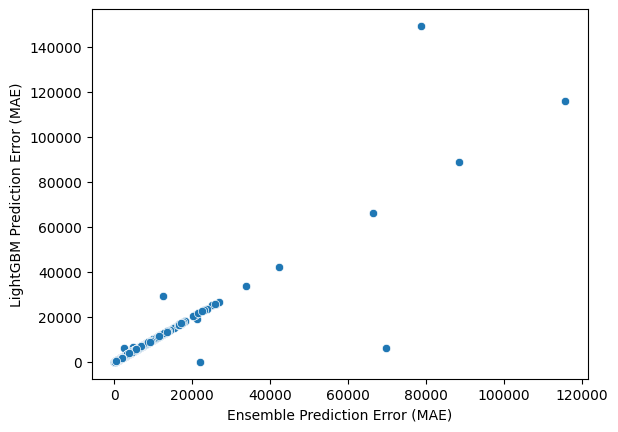

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=np.abs(val_df_preprocessed_reg["price"].to_numpy() - ensemble_pred_val),
    y=np.abs(val_df_preprocessed_reg["price"].to_numpy() - pred_price_val),
    # label="Ensemble Prediction",
)

plt.xlabel("Ensemble Prediction Error (MAE)")
plt.ylabel("LightGBM Prediction Error (MAE)")
# plt.xlim(0, 50_000)

# sns.scatterplot(
#     x=val_df_preprocessed_reg["price"].to_numpy(),
#     y=pred_price_val,
#     label="Predicted Price",
# )
# plt.xlim(-1000, 80_000)
# plt.ylim(-100, 70_000)
plt.show()